<h1>Face Detection and Privacy</h1>
This program focuses on creating an algorithm for detecting human faces under varying conditions, extracting the faces, and applying blurring to hide the eyes

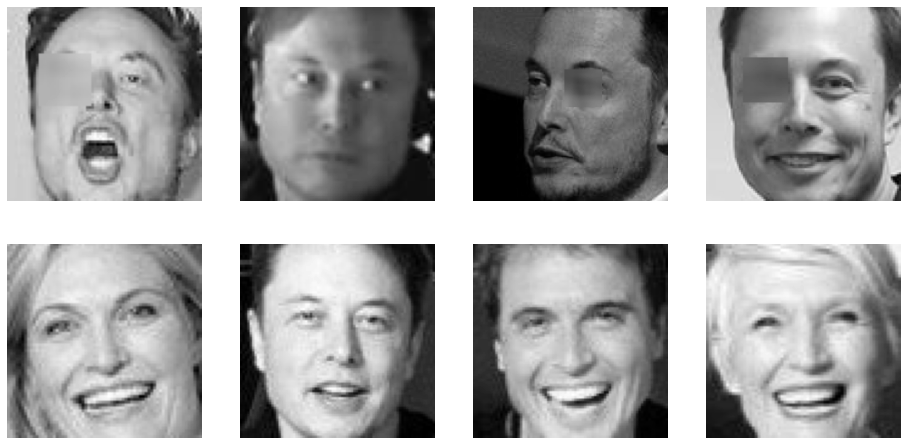

In [64]:
import cv2
import matplotlib.pyplot as plt

def load_image(image_path):
    return cv2.imread(image_path)

def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def detect_faces(gray_image):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    return face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

def detect_eyes(gray_image):
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    return eye_cascade.detectMultiScale(gray_image, scaleFactor=1.3, minNeighbors=5, minSize=(10, 10), flags=cv2.CASCADE_SCALE_IMAGE)

def detect_eyes_and_blur_faces(extracted_faces, eye_cascade_path='haarcascade_eye.xml'):
    eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

    blurred_faces = []
    for face_gray, face_color in extracted_faces:
        eyes = eye_cascade.detectMultiScale(face_gray, scaleFactor=1.3, minNeighbors=3, minSize=(10, 10))
        face_blurred = face_color.copy()
        for (ex, ey, ew, eh) in eyes:
            face_roi = face_blurred[ey:ey+eh, ex:ex+ew]
            blurred_roi = cv2.GaussianBlur(face_roi, (15, 15), 30)
            face_blurred[ey:ey+eh, ex:ex+ew] = blurred_roi
        blurred_faces.append(face_blurred)
    return blurred_faces


def process_image(image_path):
    image = load_image(image_path)
    gray_image = convert_to_grayscale(image)
    faces = detect_faces(gray_image)

    extracted_faces = []
    for (x, y, w, h) in faces:
        face_gray = gray_image[y:y+h, x:x+w]
        face_color = image[y:y+h, x:x+w]
        extracted_faces.append((face_gray, face_color))
    return extracted_faces


def draw_rectangles(image, faces, color=(0, 0, 255)):
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    return image


image_paths = ['musk_costume1.jpg', 'musk_distant.jpg', 'musk_full_body.jpg', 'musk_other_object.jpg', 'multiple_faces.jpg']

all_blurred_faces = []
for image_path in image_paths:
    extracted_faces = process_image(image_path)
    blurred_faces = detect_eyes_and_blur_faces(extracted_faces)
    all_blurred_faces.extend(blurred_faces)

# Display all images using matplotlib in one figure
fig, axes = plt.subplots(2, len(all_blurred_faces)//2, figsize=(16, 8))
for ax, face in zip(axes.flatten(), all_blurred_faces):
    gray_face = convert_to_grayscale(face)
    ax.imshow(gray_face, cmap='gray')
    ax.axis('off')
plt.show()



In [66]:
import cv2
import numpy as np

# Load the face detector cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Load the DNN-based eye detector model
eye_net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'res10_300x300_ssd_iter_140000_fp16.caffemodel')

def detect_and_blur_eyes(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # Process each detected face
    for (x, y, w, h) in faces:
        # Extract the face region
        face = image[y:y+h, x:x+w]
        
        # Convert the face region to grayscale
        face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        
        # Get the dimensions of the face region
        height, width = face.shape[:2]
        
        # Construct a blob from the face region
        blob = cv2.dnn.blobFromImage(face, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0))
        
        # Set the blob as input to the eye detector network and perform a forward pass
        eye_net.setInput(blob)
        detections = eye_net.forward()
        
        # Process each detected eye
        for i in range(0, detections.shape[2]):
            # Get the confidence of the detection
            confidence = detections[0, 0, i, 2]
            
            # Skip weak detections
            if confidence < 0.5:
                continue
            
            # Get the bounding box coordinates of the eye
            box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
            (ex, ey, ew, eh) = box.astype('int')
            
            # Blur the eye region using a Gaussian blur
            eye_roi = face[ey:ey+eh, ex:ex+ew]
            eye_roi = cv2.GaussianBlur(eye_roi, (15, 15), 0)
            face[ey:ey+eh, ex:ex+ew] = eye_roi
        
        # Put a red boundary box around the detected face in the image
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    return image



error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\caffe\caffe_io.cpp:1138: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "res10_300x300_ssd_iter_140000_fp16.caffemodel" in function 'cv::dnn::ReadProtoFromBinaryFile'
